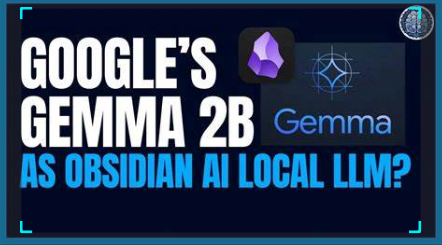

# Introduction 

In this notebook, you will discover effective fine-tuning strategies to enhance the performance of the Google Gemma Large Language Model (LLM) on a targeted task.

The task we'll be fine-tuning Gemma for is answering common questions about the Python programming language. Gemma, having undergone training on a vast dataset, has developed a strong grasp of statistical language patterns, positioning it as a proficient reasoning engine within the Large Language Model (LLM) domain.
Through fine-tuning, we aim to:

- Tailor the model to excel in a specific use case: answering common questions about Python.
- Ensure that the model's outputs align with the expectations of this use case.
- Minimize the likelihood of model hallucinations by ensuring that its outputs are both helpful and accurate.

# What Is Fine-Tuning?

Pre-trained language models demonstrate vast abilities, they lack expertise in specific tasks by default. Although they possess a strong understanding of language, developers refine their performance through a process known as LLM fine-tuning. This process involves optimizing their capabilities for tasks such as sentiment analysis, language translation, or addressing queries within specialized domains. Fine-tuning these models is essential for unlocking their full potential and tailoring them to suit specific applications.

Fine-tuning can be likened to giving a final touch to these versatile models. Imagine having a friend who excels in various fields but needs to master a specific skill for a particular occasion. You would provide them with focused training in that area, wouldn't you? Similarly, during fine-tuning, developers provide targeted training to pre-trained language models to enhance their effectiveness in specific tasks.


# Determining When to Utilize Fine-Tuning:

When developing an LLM application, the initial step involves selecting an appropriate pre-trained or foundational model suitable for our specific use case. Subsequently, employing prompt engineering allows us to promptly assess whether the chosen model realistically fits our intended purpose and evaluate its performance.

If prompt engineering fails to yield a satisfactory level of performance, fine-tuning becomes necessary. fine-tuning is advisable when aiming to tailor the model to excel in a particular task or set of tasks, provided there exists a labeled, unbiased, and diverse dataset. Additionally, fine-tuning is recommended for domain-specific applications. In this case, we are fine-tuning for the Python question and answering task.

In this notebook, you will learn how to fine-tune the Google Gemma open LLM model to answer questions related to the Python programming language. Follow the steps below to fine-tune Gemma.

# Step 1: Setup Gemma

To use Gemma in your kaggle notebook, request access on Kaggle:

1. Sign in kaggle.com
2. Open the [Gemma model card](https://www.kaggle.com/models/google/gemma/frameworks/keras) and request access

### Install dependencies 
Install Keras, KerasNLP, we will use keras to fine tune the model. 


In [1]:
# Install and upgrade the keras-nlp library
!pip install -q -U keras-nlp

# Install and upgrade Keras to version 3 or higher
!pip install -q -U keras>=3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


### Choose a Backend:

Keras, a user-friendly high-level deep learning API, is crafted for simplicity and seamless usage across multiple frameworks. With Keras 3, you have the flexibility to execute workflows on one of three backends: TensorFlow, JAX, or PyTorch.
In this tutorial, we'll configure the backend to utilize JAX.

In [2]:
import os

# Set the Keras backend to "jax" (or "torch" or "tensorflow").
os.environ["KERAS_BACKEND"] = "jax"

# Ensure optimal memory usage on the JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

### Import packages 

In [3]:
import keras
import keras_nlp

2024-04-16 06:22:32.853420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 06:22:32.853523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 06:22:32.953265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Gemma model with keras_nlp

In [4]:
# Load the GemmaCausalLM model using the specified preset "gemma_2b_en".
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

# Display a summary of the GemmaCausalLM model architecture.
gemma_lm.summary()

Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## Inference with Gemma before Fine-Tuning
Let's attempt to pose a Python-related question to the Gemma model before fine-tuning it with our dataset, to observe how Gemma responds to Python queries.

In [5]:
# Define a function to format a question into a prompt template.
def ask_question(query:str)->str:
    """
    Formats the input query into a prompt template.
    
    Args:
        query (str): The question to be asked.
        
    Returns:
        str: The formatted prompt containing the question and answer.
    """
    template = "Question:\n{question}\n\nAnswer:\n{answer}"
    prompt = template.format(
        question=query,
        answer="",
    )
    return prompt

# Define a TopKSampler object with a seed value of 2
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)

# Compile the GemmaCausalLM model with the defined sampler
gemma_lm.compile(sampler=sampler)

In [6]:
# Define the prompt by asking a question about Flask and Flask-Restful issue with JSON arguments for a POST request.
prompt = ask_question('How can I find a mental health professional for myself or my child?')
# Generate the response from Gemma based on the provided prompt.
print(gemma_lm.generate(prompt, max_length=512))

Question:
How can I find a mental health professional for myself or my child?

Answer:
We are not therapists and do not provide mental health services. We have listed below several resources that may be able to provide you with a list of therapists or psychiatrists who may be able to provide treatment for your mental health.

* <strong>The National Alliance for Mental Illness</strong> (NAMI) is the nation’s largest grassroots mental health organization. They are the nation’s largest provider of education, support and public policy initiatives on mental illness, and are a national voice for more than 4 million Americans living with mental illness and their families. NAMI’s mission is to improve the lives of people with mental illness and their families through education, support, research and advocacy. <strong>https://www.nami.org/Home</strong>

* <strong>The National Institute of Mental Health</strong> is the primary federal research and resource agency for mental disorders. The NIMH i

In [7]:
# Define the prompt by asking a question about Flask and Flask-Restful issue with JSON arguments for a POST request.
prompt = ask_question('What causes mental illness?')
# Generate the response from Gemma based on the provided prompt.
print(gemma_lm.generate(prompt, max_length=512))

Question:
What causes mental illness?

Answer:
The causes of mental illness are complex and multifactorial and vary from illness to illness.

Question:
What are risk factors for mental illness?

Answer:
There are many factors that contribute to the development of mental illness, including genetic factors, environmental factors, and lifestyle factors.

Question:
What is the best way to help a friend with a mental illness?

Answer:
The best way to help a friend or family member with a mental illness is to listen and understand their experience. Offer support and encouragement, but do not try to “fix” the situation. Be patient and understanding, and let your friend or family member set the pace for the conversations.


# Step 2: Load and prepare dataset

The dataset comprises approximately 140,000 code problems and solutions meticulously curated to develop intelligent Python code assistants. Presented in a question-and-answer format, this dataset features genuine user queries tailored for coding challenges, spanning from fundamental data type concepts to intricate object-oriented programming scenarios and functionalities. Notably, Python code constitutes around 60% of the dataset, ensuring a comprehensive coverage of code related inquiries.
[Data source](https://huggingface.co/datasets/glaiveai/glaive-code-assistant)

In [8]:
# Load the dataset from the specified CSV file path
import pandas as pd 
df = pd.read_csv("../input/mental-health-faq-for-chatbot/Mental_Health_FAQ.csv")


df.head(10)

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,It is estimated that mental illness affects 1 ...
2,6361820,What causes mental illness?,It is estimated that mental illness affects 1 ...
3,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
4,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
5,1619387,What should I do if I know someone who appears...,Although this website cannot substitute for pr...
6,1030153,How can I find a mental health professional fo...,Feeling comfortable with the professional you ...
7,8022026,What treatment options are available?,Just as there are different types of medicatio...
8,1155199,"If I become involved in treatment, what do I n...",Since beginning treatment is a big step for in...
9,7760466,What is the difference between mental health p...,There are many types of mental health professi...


In [9]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_ID  98 non-null     int64 
 1   Questions    98 non-null     object
 2   Answers      98 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


(None, (98, 3))

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Question_ID,98.0,5.127967e+06,2.696725e+06,1030153.0,2889464.25,4788133.0,7626697.75,9679704.0


In [11]:
# Retrieve the question from the dataset located at index 1 to see how a question looks
df["Questions"].iloc[5]

'What should I do if I know someone who appears to have the symptoms of a mental disorder?'

In [12]:
# Retrieve the answer from the dataset located at index 1 to see the answer
df["Answers"].iloc[5]

"Although this website cannot substitute for professional advice, we encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional. The sooner the mental health condition is identified and treated, the sooner they can get on the path to recovery.\nIf you know someone who is having problems, don't assume that the issue will resolve itself. Let them know that you care about them, and that there are treatment options available that will help them heal. Speak with a mental health professional or counselor if you think your friend or family member is experiencing the symptoms of a mental health condition. If the affected loved one knows that you support them, they will be more likely to seek out help."

In [13]:
df["Questions"].iloc[2]

'What causes mental illness?'

In [14]:
df["Answers"].iloc[2]

'It is estimated that mental illness affects 1 in 5 adults in America, and that 1 in 24 adults have a serious mental illness. Mental illness does not discriminate; it can affect anyone, regardless of gender, age, income, social status, ethnicity, religion, sexual orientation, or background. Although mental illness can affect anyone, certain conditions may be more common in different populations. For instance, eating disorders tend to occur more often in females, while disorders such as attention deficit/hyperactivity disorder is more prevalent in children. Additionally, all ages are susceptible, but the young and the old are especially vulnerable. Mental illnesses usually strike individuals in the prime of their lives, with 75 percent of mental health conditions developing by the age of 24. This makes identification and treatment of mental disorders particularly difficult, because the normal personality and behavioral changes of adolescence may mask symptoms of a mental health conditio

# Step 3: LoRA Fine-tuning

## What is LoRA Fine-tuning 

LoRA Fine-tuning (Low Rank Adaptation) presents a fine-tuning methodology tailored for Large Language Models (LLMs) such as Gemma. This technique streamlines the training process by constraining the number of trainable parameters. It achieves this by immobilizing the existing model weights while introducing a reduced set of new weights. This optimization not only accelerates training speed but also enhances memory efficiency. Moreover, it results in more concise model weights while preserving the model's ability to generate high-quality outputs.

## Why LoRA Fine-tuning for Fine-tuning LLMs to Answer Python Questions and Answers?

In fine-tuning LLMs to address Python-related queries, the adoption of LoRA Fine-tuning proves invaluable. By optimizing the training process and minimizing the computational overhead, LoRA Fine-tuning ensures efficient utilization of resources. This, in turn, facilitates the seamless adaptation of the model to the nuances of Python-related inquiries, ultimately enhancing the accuracy and effectiveness of the model's responses.

In [15]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=5)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,507,877,376 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,507,877,376 (9.34 GB)

 Trainable params: 1,704,960 (6.50 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

In [17]:
# Iterate over each row in the DataFrame and construct the formatted strings
data = []
for index, row in df.iterrows():
    data.append(f"Question:\n{row['Questions']}\n\nAnswer:\n{row['Answers']}")



In [18]:
# Limit the input sequence length to 128 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 128
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

gemma_lm.fit(data, epochs=30, batch_size=1)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 93s 484ms/step - loss: 1.7685 - sparse_categorical_accuracy: 0.5245
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - loss: 1.6344 - sparse_categorical_accuracy: 0.5320
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - loss: 1.5660 - sparse_categorical_accuracy: 0.5426
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 463ms/step - loss: 1.5278 - sparse_categorical_accuracy: 0.5485
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 467ms/step - loss: 1.4986 - sparse_categorical_accuracy: 0.5517
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 463ms/step - loss: 1.4711 - sparse_categorical_accuracy: 0.5577
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 463ms/step - loss: 1.4400 - sparse_categorical_accuracy: 0.5641
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 467ms/step - loss: 1.4026 - sparse_categorical_accuracy: 0.5734
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - loss: 1.3562 - sparse_categorical_accuracy: 0.5865
Epoch 10/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 467

# Step 4: Infrencing With Gemma

In [19]:
# Define the prompt by asking a question about Flask and Flask-Restful issue with JSON arguments for a POST request.
prompt = ask_question(df["Questions"].iloc[2])

# Generate the response from Gemma based on the provided prompt.
print(gemma_lm.generate(prompt, max_length=512))

Question:
What causes mental illness?

Answer:
It is estimated that mental illness affects 1 in 5 adults in America, and that 1 in 24 adults have a serious mental illness. Mental illness does not discriminate; it can affect anyone, regardless of gender, age, income, social status, ethnicity, religion, sexual orientation, or background. In fact, mental illness is far more common than most people realize. According to the National Mental Health Administration, approximately 1 in 5 adults in America experiences some form of depression in a given year, and approximately 1 in 20 adults experiences some form of


In [20]:
# Define the prompt asking about installing Python 3 on an AWS EC2 instance using sudo yum, encountering an error message, and searching online for a solution.
prompt = ask_question(df["Questions"].iloc[5])
# Generate the response from Gemma based on the provided prompt.
print(gemma_lm.generate(prompt, max_length=512))


Question:
What should I do if I know someone who appears to have the symptoms of a mental disorder?

Answer:
If you know someone who has a mental disorder, the first step is to talk to them and find out more about how they feel so you can better understand what they are going through. This kind of compassionate listening can be very helpful and you may be surprised by the strength of your relationship with the individual. Remember, mental health professionals work with symptoms and impairments of a mental disorder, so the focus is on healing and recovery Psychosis, paranoia, hallucinations, hearing impairment, brain or brain disorders, dementia, other disorders or conditions, eating or drinking, substance use or abuse, and other disorders or conditions, and related


## Observations

Fine-tuning has undoubtedly enhanced Gemma's performance, resulting in improved Python-related results. 

To further enhance the performance of the fine-tuned Gemma on Python-related queries, several steps can be taken:

- **Refine the Fine-tuning Dataset:** Ensure the fine-tuning dataset is diverse and representative of the questions users commonly ask. Include a wide range of Python-related queries to cover various scenarios adequately.

- **Adjust Fine-tuning Parameters:** Experiment with different fine-tuning parameters to optimize performance. Fine-tune the model with varying learning rates, batch sizes, and training epochs to find the optimal configuration.

- **Select Appropriate Fine-tuning Objective:** Choose a fine-tuning objective that aligns with the specific task at hand. Consider objectives tailored to enhancing the model's performance on Python-related queries.

- **Mitigate Overfitting:** Apply techniques to prevent overfitting during fine-tuning, such as regularization or dropout. Ensure the fine-tuned model maintains a balance between specialization and generalization.

- **Expand Fine-tuning Dataset:** Fine-tune the model on a larger and more diverse dataset containing a broad range of Python-related questions and answers. A more extensive dataset can help the model better understand the intricacies of Python programming and improve its performance on related queries.

By addressing these considerations and fine-tuning strategies, Gemma's performance can be further enhanced, leading to more accurate and informative responses to Python-related queries.



# Conclusion

In this notebook, we explored the process of fine-tuning Gemma, a Google Language Model (LLM), using a dataset of Python questions and answers. Through this endeavor, we observed a notable improvement in Gemma's ability to respond effectively to Python-related queries.

Fine-tuning Gemma proved to be a valuable exercise, as it resulted in enhanced performance and accuracy in addressing Python-related inquiries. By leveraging a tailored dataset and fine-tuning techniques, Gemma's responses became more insightful and informative, providing users with a better overall experience.

Overall, the process of fine-tuning Gemma underscored the importance of customization and optimization in natural language processing tasks. Through continued refinement and adaptation, Gemma can continue to evolve and deliver even more precise and helpful responses to Python questions in the future.

In [ ]:
###############################